In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import sklearn.linear_model as linear
import sklearn.metrics as metrics
import sklearn.model_selection as selection
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image

import torch as th
import torch.optim as optim

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [24]:
#Utility functions
def test_size(train_data, test_data):
    train_data_size = train_data.shape[0]
    train_val_percent = 0.8
    
    #We need the test_percent to be 0.2 but we know that the train_val_percent=0.8 (which comes from the train data) 
    test_size = int(round((train_data_size/train_val_percent) * 0.2, 0))
    
    return test_data.head(test_size)

In [25]:
train = pd.read_csv('cleaned_train_tag.csv', index_col=0)
test =  pd.read_csv('cleaned_test_tag.csv', index_col=0)

In [26]:
train.head()

,Age,Years Worked,Commercial,Shareholder,Has App,Owns Car,Owns House,Wages Paid,Last Payment,Investment Risk,...,Doctorate,Masters,Post-secondary,Upper Secondary,Divorced,Married,Never Married,Separated,Widowed,Flag
0,23,0,0,0,0,0,0,0,-1,0,...,1,0,0,0,0,1,0,0,0,0
1,26,0,0,0,1,0,0,0,-1,0,...,1,0,0,0,0,1,0,0,0,0
2,46,0,0,0,0,0,0,0,-1,0,...,1,0,0,0,0,1,0,0,0,0
3,30,1,0,0,0,1,0,0,-1,0,...,1,0,0,0,0,1,0,0,0,0
4,30,0,0,0,0,0,0,0,-1,0,...,1,0,0,0,0,1,0,0,0,0


In [27]:
train.shape

(39923, 40)

In [28]:
test.head()

,Age,Years Worked,Commercial,Shareholder,Has App,Owns Car,Owns House,Wages Paid,Last Payment,Investment Risk,...,Bachelors,Doctorate,Masters,Post-secondary,Upper Secondary,Divorced,Married,Never Married,Separated,Widowed
0,39,0,0,0,1,1,0,0,1210,1,...,0,0,0,0,1,0,0,1,0,0
1,40,1,0,0,1,0,0,0,-1,0,...,0,0,1,0,0,0,0,1,0,0
2,48,0,0,1,1,1,1,1,101,0,...,0,0,0,0,1,0,0,1,0,0
3,47,0,0,1,1,1,0,0,-1,0,...,1,0,0,0,0,0,0,1,0,0
4,36,2,0,0,1,1,0,0,1071,0,...,0,0,0,1,0,0,0,1,0,0


In [29]:
test.shape

(6000, 39)

In [30]:
X = train.drop(labels='Flag', axis=1)
y = train['Flag']

In [31]:
X.head()

,Age,Years Worked,Commercial,Shareholder,Has App,Owns Car,Owns House,Wages Paid,Last Payment,Investment Risk,...,Bachelors,Doctorate,Masters,Post-secondary,Upper Secondary,Divorced,Married,Never Married,Separated,Widowed
0,23,0,0,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,1,0,0,0
1,26,0,0,0,1,0,0,0,-1,0,...,0,1,0,0,0,0,1,0,0,0
2,46,0,0,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,1,0,0,0
3,30,1,0,0,0,1,0,0,-1,0,...,0,1,0,0,0,0,1,0,0,0
4,30,0,0,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,1,0,0,0


In [32]:
X.shape

(39923, 39)

In [33]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Flag, dtype: int64

In [34]:
X_test = test.copy()

As we saw in the EDA, the dataset is imbalanced (There are less fraudulent cases than non-fraudulent) so we will test 2 methods of dealing with this.
1. SMOTE (Synthetic Minority Over-sampling Technique)
2. Undersampling the majority class to match the size of the minority class

## Setting up a baseline - Logistic Regression

#### Random UnderSampling

In [35]:
# Apply random undersampling to reduce the size of the majority class
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

In [36]:
X_rus.shape[0]

17906

Now we must split these into a 70-20-10 train-test-validation split. 

In [37]:
#X_test_rus = shuffle(X_test)
#X_test_rus = test_size(X_rus, X_test_rus)

kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_rus)

#Split the training into training and validation sets
X_train_rus, X_val_rus, y_train_rus, y_val_rus = selection.train_test_split(X_rus, y_rus, test_size=0.2)

f1_rus = []

for train_index, val_index in kf.split(X_rus):
    X_train, X_val = X_rus.iloc[train_index], X_rus.iloc[val_index]
    y_train, y_val = y_rus.iloc[train_index], y_rus.iloc[val_index]
    lr = linear.LogisticRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_val_rus)
    f1_rus.append(metrics.f1_score(y_val_rus, predictions[:y_val_rus.shape[0]]))
    
mean_rus = np.mean(f1_rus)
std_rus = np.std(f1_rus)
print('Mean F1 score is ', mean_rus, ' with a std. dev of ', std_rus)
print(classification_report(y_val_rus, predictions[:y_val_rus.shape[0]]))

Mean F1 score is  0.6201756704037233  with a std. dev of  0.00930769108440474
              precision    recall  f1-score   support

           0       0.60      0.52      0.56      1766
           1       0.59      0.66      0.62      1816

    accuracy                           0.59      3582
   macro avg       0.59      0.59      0.59      3582
weighted avg       0.59      0.59      0.59      3582



#### SMOTE

In [38]:
# Apply SMOTE to oversample the minority class
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [39]:
X_smote.shape[0]

61940

Now we must split these into a 70-20-10 train-test-validation split. 

In [40]:
#X_test_smote = shuffle(X_test)
#X_test_smote = test_size(X_smote, X_test_smote)

kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_smote)

#Split the training into training and validation sets
X_train_smote, X_val_smote, y_train_smote, y_val_smote = selection.train_test_split(X_smote, y_smote, test_size=0.2)

f1_smote = []

for train_index, test_index in kf.split(X_smote):
    X_train, X_val = X_smote.iloc[train_index], X_smote.iloc[test_index]
    y_train, y_val = y_smote.iloc[train_index], y_smote.iloc[test_index]
    lr = linear.LogisticRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_val_smote)
    f1_smote.append(metrics.f1_score(y_val_smote.head(predictions.shape[0]), predictions))
    
mean_smote = np.mean(f1_smote)
std_smote = np.std(f1_smote)
print('Mean F1 score is ', mean_smote, ' with a std. dev of ', std_smote)
print(classification_report(y_val_smote.head(predictions.shape[0]), predictions))

Mean F1 score is  0.6628443185837171  with a std. dev of  0.012705123051387459
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      6187
           1       0.64      0.68      0.66      6201

    accuracy                           0.65     12388
   macro avg       0.65      0.65      0.65     12388
weighted avg       0.65      0.65      0.65     12388



Since we care more about predicting fraud (1), we will use rus going forward. Now that the baseline is set, we can test other parameters and algorithms. 
1. Penalty specifies the type of regularization to use. L1 and L2 regularization penalize large coefficients. 
2. C determines the strength of the regularization. Smaller values of C result in stronger regularization, while larger values result in weaker regularization

In [41]:
# Define the parameter grid
param_grid_lr = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}

# Create a grid search object and fit it to the training data
grid_search = selection.GridSearchCV(lr, param_grid=param_grid_lr, cv=5)
grid_search.fit(X_train_rus, y_train_rus)

# Make predictions on the test data using the best model
best_lr = grid_search.best_estimator_
y_pred_lr = best_lr.predict(X_val_rus)

# Print the classification report
print(classification_report(y_val_rus, y_pred_lr[:y_val_rus.shape[0]]))

              precision    recall  f1-score   support

           0       0.60      0.52      0.56      1766
           1       0.59      0.66      0.62      1816

    accuracy                           0.59      3582
   macro avg       0.59      0.59      0.59      3582
weighted avg       0.59      0.59      0.59      3582



It seems like there aren't significant improvements we can make to the logistic regression so we will move on to another algorithm

## Random Forest

In [42]:
#X_test_rus = shuffle(X_test)
#X_test_rus = test_size(X_rus, X_test_rus)

kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_rus)

#Split the training into training and validation sets
X_train_rus, X_val_rus, y_train_rus, y_val_rus = selection.train_test_split(X_rus, y_rus, test_size=0.2)

f1_rf = []

for train_index, val_index in kf.split(X_rus):
    X_train, X_val = X_rus.iloc[train_index], X_rus.iloc[val_index]
    y_train, y_val = y_rus.iloc[train_index], y_rus.iloc[val_index]
    rf = RandomForestClassifier(n_estimators=200)
    rf.fit(X_train_rus, y_train_rus)
    y_pred_rf = rf.predict(X_val_rus)
    f1_rf.append(metrics.f1_score(y_val_rus, y_pred_rf[:y_val_rus.shape[0]]))
    
mean_rf = np.mean(f1_rf)
std_rf = np.std(f1_rf)
print('Mean F1 score is ', mean_rf, ' with a std. dev of ', std_rf)
print(classification_report(y_val_rus, y_pred_rf[:y_val_rus.shape[0]]))

Mean F1 score is  0.607074459956283  with a std. dev of  0.00259336810908085
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1811
           1       0.61      0.60      0.61      1771

    accuracy                           0.61      3582
   macro avg       0.61      0.61      0.61      3582
weighted avg       0.61      0.61      0.61      3582



In [43]:
# Train a single decision tree classifier and evaluate its performance without hyperparameters
dt = DecisionTreeClassifier()
dt.fit(X_train_rus, y_train_rus)
y_pred_dt = dt.predict(X_val_rus)
print("Decision Tree Classification Report:\n", classification_report(y_val_rus, y_pred_dt[:y_val_rus.shape[0]]))

# Train a random forest classifier and evaluate its performance without hyperparameters
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_rus, y_train_rus)
y_pred_rf = rf.predict(X_val_rus)
print("Random Forest Classification Report:\n", classification_report(y_val_rus, y_pred_rf[:y_val_rus.shape[0]]))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.55      0.56      1811
           1       0.55      0.55      0.55      1771

    accuracy                           0.55      3582
   macro avg       0.55      0.55      0.55      3582
weighted avg       0.55      0.55      0.55      3582

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62      1811
           1       0.61      0.60      0.61      1771

    accuracy                           0.61      3582
   macro avg       0.61      0.61      0.61      3582
weighted avg       0.61      0.61      0.61      3582



In [44]:
# Define the parameter grid
param_grid_rf = {'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_leaf': [1, 2, 4]}

# Create a grid search object and fit it to the training data
grid_search = selection.GridSearchCV(rf, param_grid=param_grid_rf, cv=5)
grid_search.fit(X_train_rus, y_train_rus)

# Make predictions on the test data using the best model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_val_rus)

# Print the classification report
print(classification_report(y_val_rus, y_pred_rf[:y_val_rus.shape[0]]))

              precision    recall  f1-score   support

           0       0.63      0.62      0.63      1811
           1       0.62      0.64      0.63      1771

    accuracy                           0.63      3582
   macro avg       0.63      0.63      0.63      3582
weighted avg       0.63      0.63      0.63      3582



## Support Vector Machine

In [45]:
#X_test_rus = shuffle(X_test)
#X_test_rus = test_size(X_rus, X_test_rus)

kf = selection.KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X_rus)

#Split the training into training and validation sets
X_train_rus, X_val_rus, y_train_rus, y_val_rus = selection.train_test_split(X_rus, y_rus, test_size=0.2)

f1_rus = []

for train_index, val_index in kf.split(X_rus):
    X_train, X_val = X_rus.iloc[train_index], X_rus.iloc[val_index]
    y_train, y_val = y_rus.iloc[train_index], y_rus.iloc[val_index]
    sv = svm.SVC()
    sv.fit(X_train, y_train)
    predictions = sv.predict(X_val_rus)
    f1_rus.append(metrics.f1_score(y_val_rus, predictions[:y_val_rus.shape[0]]))
    
mean_rus = np.mean(f1_rus)
std_rus = np.std(f1_rus)
print('Mean F1 score is ', mean_rus, ' with a std. dev of ', std_rus)
print(classification_report(y_val_rus, predictions[:y_val_rus.shape[0]]))

Mean F1 score is  0.6187829690808839  with a std. dev of  0.0012736361478267479
              precision    recall  f1-score   support

           0       0.60      0.44      0.51      1796
           1       0.56      0.70      0.62      1786

    accuracy                           0.57      3582
   macro avg       0.58      0.57      0.56      3582
weighted avg       0.58      0.57      0.56      3582



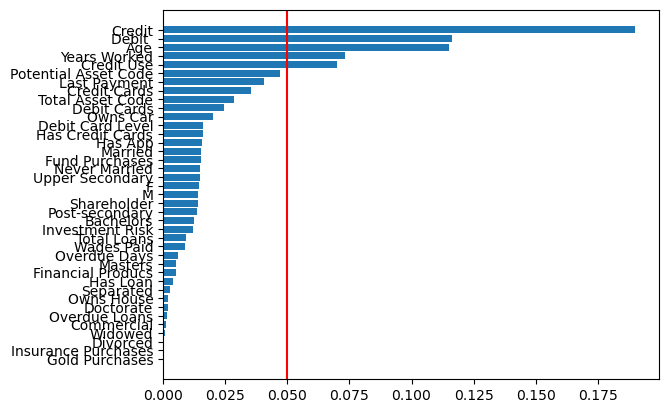

In [46]:
features = list(X_train_rus.columns.values)
f_i = list(zip(features,best_rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.axvline(x = 0.05, color = 'r')

plt.show()

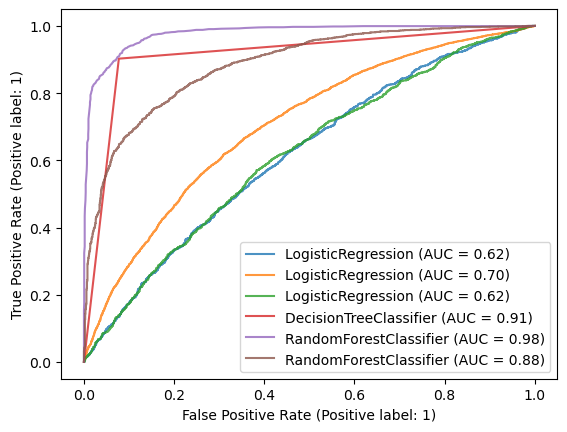

In [47]:
ax = plt.gca()

rus_disp = metrics.RocCurveDisplay.from_estimator(lr, X_val_rus[:y_val_rus.shape[0]], y_val_rus, ax=ax, alpha=0.8)
smote_disp = metrics.RocCurveDisplay.from_estimator(lr, X_val_smote, y_val_smote.head(X_val_smote.shape[0]), ax=ax, alpha=0.8)
best_lr_disp = metrics.RocCurveDisplay.from_estimator(best_lr, X_val_rus[:y_val_rus.shape[0]], y_val_rus, ax=ax, alpha=0.8)
dt_disp = metrics.RocCurveDisplay.from_estimator(dt, X_val_rus[:y_val_rus.shape[0]], y_val_rus, ax=ax, alpha=0.8)
rf_disp = metrics.RocCurveDisplay.from_estimator(rf, X_val_rus[:y_val_rus.shape[0]], y_val_rus, ax=ax, alpha=0.8)
best_rf_disp = metrics.RocCurveDisplay.from_estimator(best_rf, X_val_rus[:y_val_rus.shape[0]], y_val_rus, ax=ax, alpha=0.8)
plt.show()

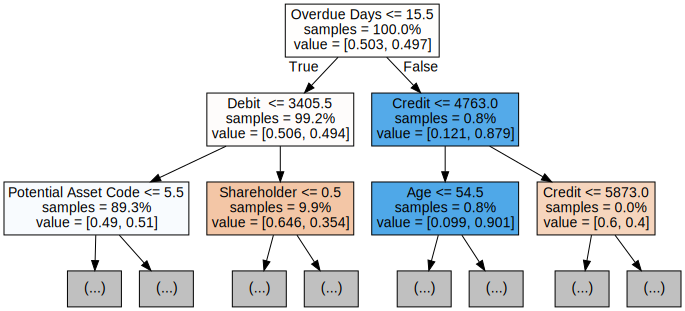

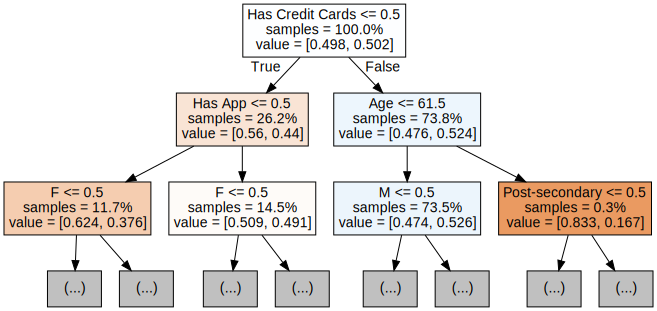

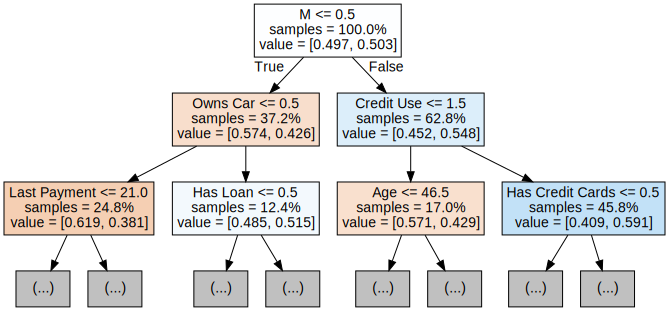

In [48]:
import graphviz
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_rus.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [1]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

features = list(X_train_rus.columns.values)

perm_importance = permutation_importance(sv, X_train_rus, y_train_rus)
f_i = list(zip(features,perm_importance))

plt.xlabel("Permutation Importance")
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.axvline(x = 0.05, color = 'r')

plt.show()

c:\Users\gersh\anaconda3\envs\Lab\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'X_train_rus' is not defined